"prepare faces" kernel output files are used as dataset

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [4]:
batch_size=8

In [5]:
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
dataset=torchvision.datasets.ImageFolder("face_age",transform=transform)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=2)

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [ ]:
model=Model().cuda()
criterion=nn.MSELoss()
optim=torch.optim.Adam(model.parameters(),lr=.001)

In [ ]:
dataiter = iter(dataloader)
x, y = dataiter.next()
x=x.cuda()
y=y.reshape((batch_size,1)).cuda().type(torch.float32)/100
print(y,y.dtype)

In [ ]:
import datetime
timea = datetime.datetime.now()
for i in range(100000):
    dataiter = iter(dataloader)
    x, y = dataiter.next()
    x=x.cuda()
    y=.01+y.reshape((batch_size,1)).cuda().type(torch.float32)/100
    z=model(x)

    loss=criterion(z,y)
    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 10000 == 0:
        print(i, loss)
        
timeb = datetime.datetime.now()
print("time in seconds: ",(timeb-timea).seconds)

In [ ]:
torch.save(model.state_dict(), "model.pt")

In [9]:
model=Model()
model.load_state_dict(torch.load("model.pt",map_location='cpu'))
model.eval()

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

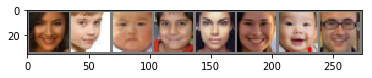

[22, 9, 1, 8, 22, 29, 1, 35]
[25, 11, 0, 13, 22, 27, 0, 33]


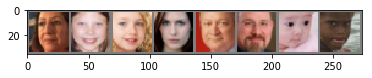

[85, 15, 6, 33, 52, 42, 1, 8]
[83, 13, 7, 25, 52, 42, 0, 14]


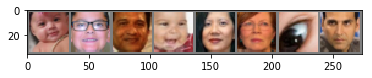

[1, 12, 47, 2, 37, 65, 1, 37]
[0, 14, 40, 0, 29, 63, 0, 41]


In [24]:
for i in range(3):
    dataiter = iter(dataloader)
    x, y = dataiter.next()
    y=.01+y.reshape((batch_size,1)).type(torch.float32)/100
    z=model(x)

    imshow(torchvision.utils.make_grid(x))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,8).tolist()[0])
    print(z.reshape(1,8).tolist()[0])

In [10]:
from PIL import Image
import PIL

In [22]:
testset=torchvision.datasets.ImageFolder("tmp",transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True,num_workers=2)

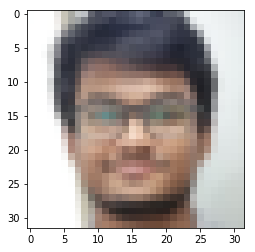

Predicted age:  [21]


In [23]:
testiter = iter(testloader)
x, y = testiter.next()
z=model(x)

imshow(torchvision.utils.make_grid(x))
z=(z*100).type(torch.int64)
print("Predicted age: ",z.reshape(1,1).tolist()[0])